# BigGAN Hessian Computation
This repo tries to prove whether we could compute hessian of BigGAN (activation or image similarity) by forward finite difference method.

In [1]:
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample
import torch
import torch.optim as optim
import torch.nn.functional as F
from hessian_eigenthings.power_iter import Operator, deflated_power_iteration
from hessian_eigenthings.lanczos import lanczos
from lanczos_generalized import lanczos_generalized
from GAN_hvp_operator import GANHVPOperator, GANForwardHVPOperator, compute_hessian_eigenthings
#%
import numpy as np
import matplotlib.pylab as plt
from time import time
from os.path import join
from imageio import imwrite
from build_montages import build_montages, color_framed_montages
import torchvision.models as tv

In [47]:
BGAN = BigGAN.from_pretrained("biggan-deep-256")
#%
for param in BGAN.parameters():
    param.requires_grad_(False)
BGAN.cuda()
#%
alexnet = tv.alexnet(pretrained=True).cuda()
alexnet.eval() # this is important or there will be trial to trial variability due to DropOut
for param in alexnet.parameters():
    param.requires_grad_(False)

In [48]:
from FeatLinModel import FeatLinModel, get_model_layers

In [38]:
from torchvision.transforms import Normalize, Compose
RGB_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1).cuda()
preprocess = Compose([lambda img: (F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) - RGB_mean) / RGB_std])
preprocess_resize = Compose([lambda img: F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) ])

In [20]:
%%time
feat = torch.randn(256).cuda().requires_grad_(True)
img = BGAN.generator(feat, 0.7)
obj = img.mean()
# obj.backward()

Wall time: 200 ms


In [21]:
%%time
from hessian import hessian
H = hessian(obj, feat)

In [23]:
%%time
eigval, eigvec = np.linalg.eigh(H.cpu().numpy())
plt.plot(sorted(eigval))
plt.show()

Wall time: 37.4 ms


In [ ]:
objective = FeatLinModel(alexnet, layername="features_10", type="neuron", chan=10, pos=(7, 7))

In [6]:
feat = torch.randn(256).cuda().requires_grad_(True)
act = objective(preprocess(BGAN.generator(feat, 0.7)))

In [8]:
%%time
from hessian import hessian
H_act = hessian(act, feat)

Wall time: 57.9 s


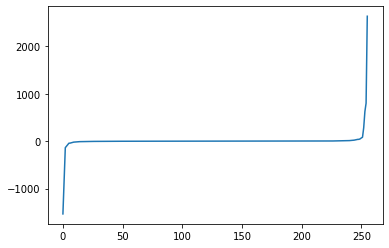

Wall time: 139 ms


In [9]:
%%time
eigval, eigvec = np.linalg.eigh(H_act.cpu().numpy())
plt.plot(sorted(eigval))
plt.show()

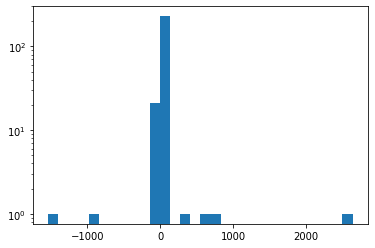

In [10]:
plt.hist(eigval, bins=30, log=True)
plt.show()

In [15]:
del objective

Above, we have proved that we can compute hessian for BigGAN by backprop 2 times and we can find its spectrum. 

Next, I'd like to examine its spectrum in noise space and code space

In [7]:
onehot = torch.zeros(1, 1000).requires_grad_(False)
onehot[0, 1] = 1

In [ ]:
classvec = BGAN.embeddings(onehot.cuda())
noisevec = torch.from_numpy(truncated_noise_sample(1, 128, 0.6))
#%
img = BGAN.generator(torch.cat((noisevec.cuda(), classvec, ), dim=1), 0.6)
#%
plt.imshow((img.cpu().permute(2,3,1,0).squeeze() + 1.0) / 2.0)
plt.axis('off')
plt.show()

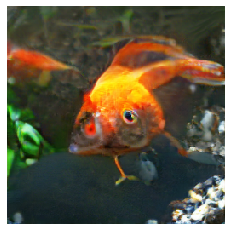

In [48]:
classvec = BGAN.embeddings(onehot.cuda())
noisevec = torch.from_numpy(truncated_noise_sample(1, 128, 0.6)).cuda()
classvec.requires_grad_(True)
img = BGAN.generator(torch.cat((noisevec, classvec, ), dim=1), 0.6)
act = alexnet(preprocess_resize(img))[0,1]
plt.imshow((img.detach().cpu().permute(2,3,1,0).squeeze() + 1.0) / 2.0)
plt.axis('off')
plt.show()

In [52]:
%%time
H_class = hessian(act, classvec)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [50]:
act.backward()

tensor(0.9052, device='cuda:0', grad_fn=<NormBackward0>)
step 9: -24.05
step 19: -18.74
step 29: -20.75
step 39: -20.20
step 49: -28.07
step 59: -26.67
step 69: -27.67
step 79: -26.46
step 89: -26.18
step 99: -28.46
step 109: -24.55
step 119: -28.89
step 129: -29.02
step 139: -26.73
step 149: -28.15
step 159: -26.63
step 169: -24.40
step 179: -28.80
step 189: -29.67
step 199: -26.37
tensor(0.9581, device='cuda:0', grad_fn=<NormBackward0>)


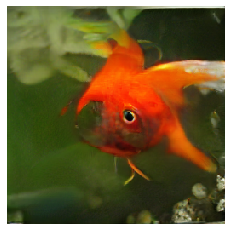

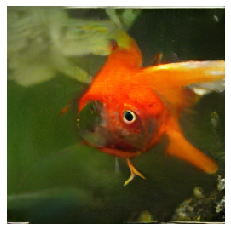

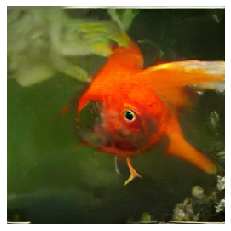

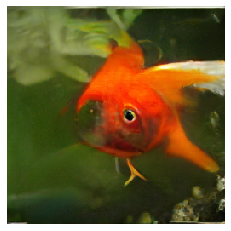

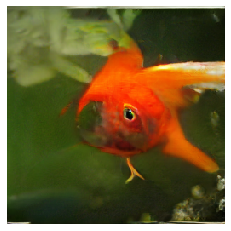

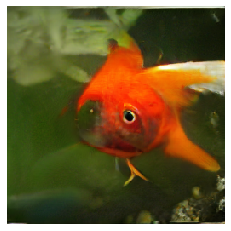

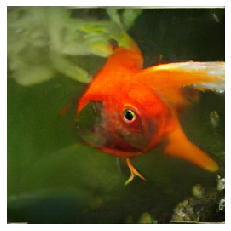

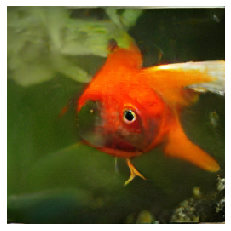

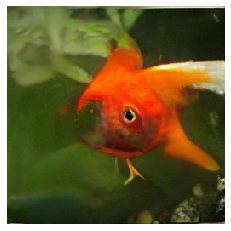

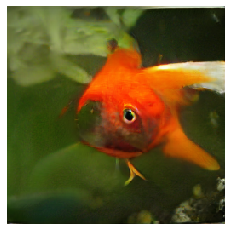

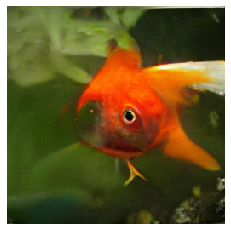

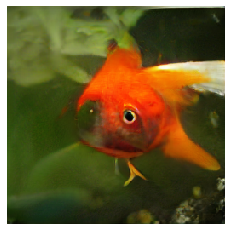

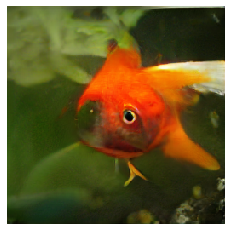

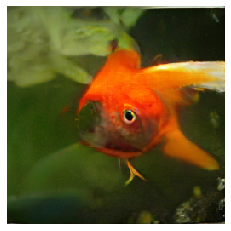

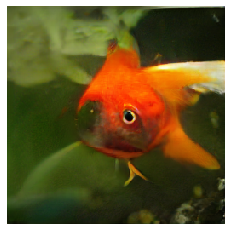

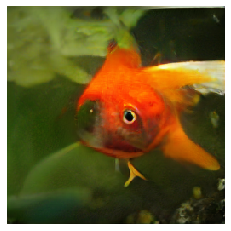

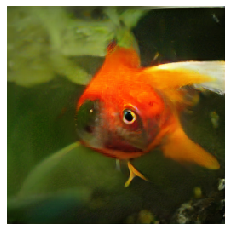

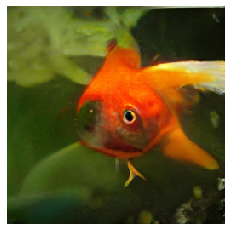

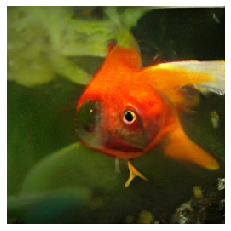

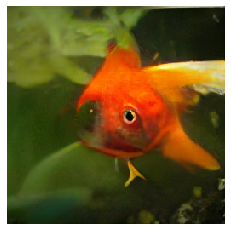

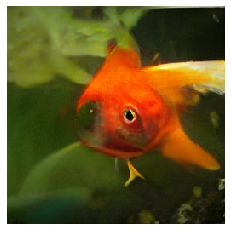

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
onehot = torch.zeros(1, 1000).requires_grad_(False)
onehot[0, 1] = 1
classvec = BGAN.embeddings(onehot.cuda())
noisevec = torch.from_numpy(truncated_noise_sample(1, 128, 0.6)).cuda()
alexnet.train(True)
classvec.requires_grad_(True)
print(classvec.norm())
optimizer = optim.Adam([classvec], lr=1.5E-3)
for step in range(200):
    optimizer.zero_grad()
    img = BGAN.generator(torch.cat((noisevec, classvec, ), dim=1), 0.6)
    obj =  - alexnet(preprocess_resize(img))[0,1]
    obj.backward()
    optimizer.step()
    if np.mod((step + 1), 10) == 0:
        print("step %d: %.2f"%(step, obj.item()))
        plt.imshow((img.detach().cpu().permute(2,3,1,0).squeeze() + 1.0) / 2.0)
        plt.axis('off')
        plt.show()
print(classvec.norm())
img = BGAN.generator(torch.cat((noisevec, classvec, ), dim=1), 0.6)
act = alexnet(preprocess_resize(img))[0,1]
plt.imshow((img.detach().cpu().permute(2,3,1,0).squeeze() + 1.0) / 2.0)
plt.axis('off')
plt.show()
alexnet.eval()

In [13]:
classvec.grad.norm() / classvec.norm()

tensor(124.2161, device='cuda:0', grad_fn=<DivBackward0>)

In [17]:
classvec.norm()

tensor(0.9480, device='cuda:0', grad_fn=<NormBackward0>)

 [================================================================>]  Step: 284ms | Tot: 36s737ms | full hessian columns: 127 of 128 128/128 
Wall time: 38.1 s


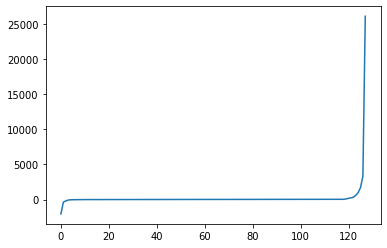

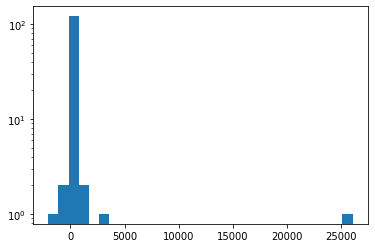

In [10]:
%%time
classvec.requires_grad_(True)
noisevec.requires_grad_(False)
img = BGAN.generator(torch.cat((noisevec, classvec, ), dim=1), 0.6)
act =  - alexnet(preprocess_resize(img))[0,1]
H_act_class = get_full_hessian(act, classvec)
#%
eigval_class, eigvec_class = np.linalg.eigh(H_act_class)
plt.plot(sorted(eigval_class))
plt.show()
plt.hist(eigval_class, bins=30, log=True)
plt.show()

In [31]:
H_act_class

array([[ 230.52536 ,  -37.311035,  131.00879 , ..., -149.1956  ,
        -391.32547 ,  331.35745 ],
       [ -37.311733,  320.7262  , -145.67722 , ..., -142.0322  ,
         218.04588 ,  -85.42906 ],
       [ 131.00894 , -145.67744 ,  203.42514 , ...,  -27.758781,
        -350.4212  ,  285.5248  ],
       ...,
       [-149.19519 , -142.03287 ,  -27.759111, ...,  236.58258 ,
         181.91653 , -250.79434 ],
       [-391.326   ,  218.04536 , -350.42084 , ...,  181.9172  ,
         810.81586 , -718.5424  ],
       [ 331.35767 ,  -85.4283  ,  285.52515 , ..., -250.79459 ,
        -718.54285 ,  698.83435 ]], dtype=float32)

In [7]:
from IPython.display import clear_output
from hessian_eigenthings.utils import progress_bar
def get_full_hessian(loss, param):
    # from https://discuss.pytorch.org/t/compute-the-hessian-matrix-of-a-network/15270/3
    # modified from hessian_eigenthings repo. api follows hessian.hessian
    hessian_size = param.numel()
    hessian = torch.zeros(hessian_size, hessian_size)
    loss_grad = torch.autograd.grad(loss, param, create_graph=True, retain_graph=True, only_inputs=True)[0].view(-1)
    for idx in range(hessian_size):
        clear_output(wait = True)
        progress_bar(
            idx, hessian_size, "full hessian columns: %d of %d" % (idx, hessian_size)
        )
        grad2rd = torch.autograd.grad(loss_grad[idx], param, create_graph=False, retain_graph=True, only_inputs=True)
        hessian[idx] = grad2rd[0].view(-1)
    return hessian.cpu().data.numpy()

In [56]:
def tuning_plot_BigGAN(G, preprocess, objective, feat, eigvals, eigvects, space="class",
        eig_id_arr=(0, 1, 5, 10, 15, 20, 40, 60, 80,99, 120, 127),
        save_indiv=False, save_row=False, summary_dir="", veclabel="eig", titlestr="", lim=(-1, 1), ticks=21, 
        pad=24, cmap=plt.cm.viridis, RND=None):
    if RND is None: RND = np.random.randint(100)
    vec_norm = feat.norm().item()
    
    if space == "class":
        step = 2 / (ticks - 1)
        step_arr = torch.linspace(lim[0], lim[1], ticks)
        ref_vect = feat.detach().clone()
    elif space == "noise":
        theta_arr_deg =  np.linspace(-90, 90, ticks) # np.arange(-5, 6)
        theta_arr = theta_arr_deg / 180 * np.pi
        ref_vect = (feat / vec_norm).cpu().numpy()
    img_list_all = []
    scores_col = [] # array version of scores
    scores_all = [] # list version of scores
    # eig_id_arr = [0, 1, 5, 10, 15, 20, 40, 60, 80,99,150,200,250,299,450]
    batch = 6
    for eig_id in eig_id_arr: #,600,799]:
        # eig_id = 0
        perturb_vect = eigvects[eig_id,:]  # PC_vectors[1,:]
        if space == "class":
            perturb_vecs = step_arr.unsqueeze(1) @ torch.from_numpy(perturb_vect).unsqueeze(0)
            perturb_vecs = torch.cat((torch.zeros_like(perturb_vecs), perturb_vecs), dim=1)
            codes_arc = perturb_vecs.cuda() + ref_vect.cuda()
            codes_arc.requires_grad_(False)
            csr = 0
            with torch.no_grad():
                img_batchs = []
                while csr < codes_arc.size(0):
                    csr_end = min(csr + batch, codes_arc.size(0))
                    imgs = G.generator(codes_arc[csr:csr_end, :], 0.6)
                    img_batchs.append(imgs)
                    csr = csr_end
                imgs = torch.cat(tuple(img_batchs), dim=0)
        elif space == "noise":
            codes_arc = np.array([np.cos(theta_arr),
                              np.sin(theta_arr) ]).T @ np.array([ref_vect, perturb_vect])
            norms = np.linalg.norm(codes_arc, axis=1)
            codes_arc = codes_arc / norms[:, np.newaxis] * vec_norm
            imgs = G.visualize(torch.from_numpy(codes_arc).float().cuda())
        scores = - objective(preprocess(imgs), scaler=False)
        scores_col.append(scores.cpu().numpy())
        scores_all.extend(scores.cpu().squeeze().tolist())
        npimgs = np.clip((imgs.detach().cpu().permute([2, 3, 1, 0]).numpy() + 1) / 2, 0, 1)

        if save_indiv:
            for i in range(npimgs.shape[3]):
                angle = theta_arr_deg[i]
                imwrite(join(newimg_dir, "norm%d_%s%d_ang%d.jpg" % (vec_norm, veclabel, eig_id, angle)), npimgs[:, :, :, i])

        img_list = [npimgs[:, :, :, i] for i in range(npimgs.shape[3])]
        img_list_all.extend(img_list)
        if save_row:
            mtg1 = build_montages(img_list, [256, 256], [ticks, 1])[0]
            imwrite(join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, eig_id)), mtg1)
    mtg_all = build_montages(img_list_all, [256, 256], [ticks, int(len(img_list_all) // ticks)])[0]
    imwrite(join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, RND)), mtg_all)
    print("Write to ", join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, RND)))

    mtg_frm = color_framed_montages(img_list_all, [256, 256], [ticks, int(len(img_list_all) // ticks)], scores_all, pad=pad, cmap=cmap)[0]
    imwrite(join(summary_dir, "norm%d_%s_framed_%d.jpg" % (vec_norm, veclabel, RND)), mtg_frm)
    print("Write to ", join(summary_dir, "norm%d_%s_framed_%d.jpg" % (vec_norm, veclabel, RND)))
    
    scores_col = np.array(scores_col)
    plt.figure(figsize=[8,10],dpi=100)
    plt.matshow(scores_col)
    plt.axis('image')
    plt.title("Neural Tuning Towards Different Eigen Vectors of Activation")
    plt.xlabel("Angle")
    plt.ylabel("Eigen Vector #")
    eiglabel = ["%d %.3f"%(id,eig) for id, eig in zip(eig_id_arr, eigvals[list(eig_id_arr)])]
    plt.yticks(range(len(eig_id_arr)), eiglabel) # eig_id_arr
    plt.ylim(top=-0.5, bottom=len(eig_id_arr) - 0.5)
    plt.colorbar()
    plt.suptitle(titlestr)
    plt.savefig(join(summary_dir, "norm%d_%s_score_mat_%02d.jpg" % (vec_norm, veclabel, RND)) , dpi=100, bbox_inches='tight')
    plt.show()
    print("Write to ", join(summary_dir, "norm%d_%s_score_mat_%02d.jpg" % (vec_norm, veclabel, RND)) )
    return img_list, scores_col

In [51]:
savedir = r"E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN"
# objective = lambda img, scaler: alexnet(img)[:,1].mean() if scaler else alexnet(img)[:,1]
alexnet.eval()
objective = FeatLinModel(alexnet, layername="classifier_6", type="neuron", chan=1, pos=(1,1))
ref_vect = torch.cat((noisevec.detach(), classvec.detach(), ), dim=1)

['classifier_6']


In [53]:
img_list, scores_col = tuning_plot_BigGAN(BGAN, preprocess_resize, objective, 
            ref_vect, eigval_class, eigvec_class, eig_id_arr=(1,2,3,4,5,6,7,8,9,10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120), 
            space="class", ticks=11, lim=(-2,2), summary_dir=savedir)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 4.18 GiB already allocated; 1.14 MiB free; 437.52 MiB cached)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_78.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_framed_78.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_score_mat_78.jpg


<Figure size 800x1000 with 0 Axes>

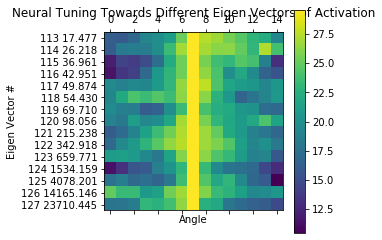

In [63]:
sort_idx = np.argsort(eigval_class)
img_list, scores_col = tuning_plot_BigGAN(BGAN, preprocess_resize, objective, 
            ref_vect, eigval_class, eigvec_class, eig_id_arr=sort_idx[-15:], 
            space="class", ticks=15, lim=(-1,1), summary_dir=savedir)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_33.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_framed_33.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\BigGAN\norm5_eig_score_mat_33.jpg


<Figure size 800x1000 with 0 Axes>

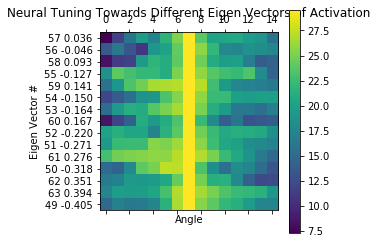

In [64]:
sort_idx = np.argsort(np.abs(eigval_class))
img_list, scores_col = tuning_plot_BigGAN(BGAN, preprocess_resize, objective, 
            ref_vect, eigval_class, eigvec_class, eig_id_arr=sort_idx[:15], 
            space="class", ticks=15, lim=(-1,1), summary_dir=savedir)

In [45]:
del BGAN, alexnet, objective
torch.cuda.empty_cache()

In [58]:
del act
torch.cuda.empty_cache()

In [70]:
import torch.nn as nn
class BigGAN_wrapper():#nn.Module
    def __init__(self, BigGAN, space="class"):
        self.BigGAN = BigGAN
        self.space = space

    def visualize(self, code, scale=1.0):
        imgs = self.BigGAN.generator(code, 0.6)
        return torch.clamp((imgs + 1.0) / 2.0, 0, 1) * scale

In [71]:
G = BigGAN_wrapper(BGAN)

In [74]:
G.visualize(torch.randn(1,256).cuda())

tensor([[[[0.2574, 0.3458, 0.2768,  ..., 0.6612, 0.6223, 0.6142],
          [0.1161, 0.1878, 0.1437,  ..., 0.6485, 0.6618, 0.6809],
          [0.1009, 0.1920, 0.1423,  ..., 0.6777, 0.6744, 0.6732],
          ...,
          [0.6011, 0.5718, 0.5864,  ..., 0.6210, 0.5960, 0.6115],
          [0.5506, 0.5880, 0.5886,  ..., 0.6822, 0.6198, 0.6183],
          [0.4746, 0.4772, 0.4938,  ..., 0.6069, 0.6122, 0.6021]],

         [[0.1323, 0.3356, 0.2626,  ..., 0.4807, 0.4832, 0.4961],
          [0.0496, 0.1835, 0.1164,  ..., 0.5412, 0.5078, 0.5719],
          [0.0419, 0.1305, 0.0800,  ..., 0.5564, 0.5452, 0.6011],
          ...,
          [0.4229, 0.4148, 0.4049,  ..., 0.5273, 0.4805, 0.5270],
          [0.3721, 0.4410, 0.4120,  ..., 0.5573, 0.5096, 0.5301],
          [0.3182, 0.3510, 0.3573,  ..., 0.4442, 0.4562, 0.4975]],

         [[0.2457, 0.3155, 0.2431,  ..., 0.5321, 0.5337, 0.4740],
          [0.1093, 0.2024, 0.1117,  ..., 0.5446, 0.5409, 0.5818],
          [0.0807, 0.1508, 0.0843,  ..., 0

In [78]:
RGB_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1).cuda()
preprocess = Compose([lambda img: (F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) - RGB_mean) / RGB_std])
objective = FeatLinModel(alexnet, layername="classifier_6", type="neuron", chan=1, pos=(1, 1))
ref_vect = torch.cat((noisevec, classvec, ), dim=1).detach().clone()
BGANHVP = GANForwardHVPOperator(G, ref_vect, objective, preprocess=preprocess)

['classifier_6']


In [ ]:
%%time
t0 = time()
eigvals, eigvects = lanczos(BGANHVP, num_eigenthings=2000, use_gpu=True)
print(time() - t0)  # 40 sec 146sec for 2000 eigens
eigvals = eigvals[::-1]
eigvects = eigvects[::-1, :]